CMPT 2400: Exploratory Data Analysis Data Project
Prepared by Laura Brin, Sandra Alex & Annabell Rodriguez

loading libraries

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
import calendar
from calendar import month_name as mn
import plotly.express as px

# This makes it so we are able to see 100 rows when displaying the data
pd.set_option("display.max_rows", 100)

loading datasets

In [38]:
pass_df=pd.read_csv("dataset/International_Report_Passengers.csv")
depart_df=pd.read_csv("dataset/International_Report_Departures.csv")
world_airp_codes_df=pd.read_csv("dataset/world_airport_codes.csv")

### Posed Problem: Flight Delay Propagation Mitigation

International travel involves a web of interconnected airports in hundreds of countries every day of the year. 
The ripple effect caused by a cancelled or delayed flight can cause issues with missed connections, missing baggage, carrier fines, reimbursed customers and staffing issues.

According to the Federal Aviation Administration, Delay Propagation occurs when three conditions are met simultaneously (https://aspm.faa.gov/aspmhelp/index/Delay_Propagation.html#:~:text=Delay%20propagation%20occurs%20when%20a,identified%20by%20a%20tail%20number.):

- A flight arrives late at an airport.
- A flight departs late in subsequent stages.
- A flight arrives late at the next destination.


### Posed Solution

We would like to pitch a ML solution using this dataset that would assist with real time decisions for domestic flight delays. When domestic flight centers experience multiple delays, air traffic decision makers can use the model to help predict which flights should be prioritized for take-off to reduce flight delay propagation into international connecting flights. It will do this by looking at the relationship between the flight's intended landing airport, the number of international airports that site connects with, how many flights leave that site, the region of the airport and the time of year.

### Observing Departures Dataset

This dataset contains data on all the flights between US gateways and non-US gateways. It is a record of international flights departing US and can be used to highlight busiest airports, and peak times for flight volume

There are multiple abbreviations used in this section:
* DOT: Department of Transportation
* FAA: Federal Aviation Administration
* IATA: International Air Transportation Association
* ICAO: International Civil Aviation Organization

    #Laura

#### Features

Date- in MM/DD/YYYY format

Year

Month

> usg_apt_id: US Gateway Airport ID- assigned by US DOT to identify airport

> usg_apt: US Gateway Airport Code- usually assigned by IATA but in absence of IATA designation, may show FAA-assigned code. For full list of World Airport codes see the Bureau of Transportation Statistics: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes 

        These two features are related. They represent the numerical location code (US) and three letter code for location identification, respectively. These should correlate 1:1 except where FAA coding was used in the absence of IATA coding. 


usg_wac: US Gateway World Area code- assigned by US DOT to represent a geographic territory. 
* 1-99 USA, 
* 100-199 Central America, 
* 200-299 Caribbean, Bahamas and Bermuda, 
* 300-399 South America, 
* 400-499 Europe, 
* 500-599 Africa, 
* 600-699 Middle East, 
* 700-800 Far East/Asia, 
* 801-899 Antarctica, Australasia and Oceania, 
* 900-999 Canada and Greenland 
codes groupings from https://en.wikipedia.org/wiki/World_Area_Codes



> fg_apt_id: Foreign Gateway Airport ID-assigned by US DOT to identify an airport

> fg_apt: Foreign Gateway Airport Code- usually assigned by IATA but in absence of IATA designation, may show FAA assigned code

> fg_wac: Foreign Gateway World Area Code- Assigned by US DOT to represent territory. For code groups see above in usg_wac comments

        These three features are related. They represent the five digit numerical location code (US), three letter code for location identification (International), and three digit numerical location code (international), respectively.

> airlineid: Airline ID assigned by US DOT to identify an air carrier

> carrier: IATA assigned air carrier code. If carrier has no IATA code, ICAO- or FAA assigned code may be used. These are mixed letter/number codes. For full list of air carrier codes see the Bureau of Transportation Statistics: https://www.bts.gov/topics/airlines-and-airports/airline-codes 

        These two features are related. They represent the five digit numerical airline ID (US) and the two or three character air carrier id (international). These should correlate 1:1 except where IATA coding was absent. 

carriergroup: group code. 1=US domestic air carriers, 0=foreign air carriers

type: type of the metrics- this is a single code for this dataset= "Departures"

> Scheduled: metric flow by scheduled service operations. Scheduled flights are those commercially available for indivdual purchase

> Charter: metric flown by charter operations. Charter flights are booked by a group or consortium responsible for all seats on the flight. This is commonly reffered to as private flights

        These two features are related. Flights are listed as either scheduled or charter. Flights on the same day, from the same airline id, with the same take off and landing sites are recorded as a count metric

Total: scheduled+charter flight counts



        Notes: 
need to set date format correctly
year/month-numerical-any need for month to be in categorical?
need to check where more than 2 usg_apt is assigned to usg_apt_id and relabel
important pieces- US gatewayForeign Gateway and US_ world Area codeforeign world area code
year,month,
apt_ids and airlineid all as numeric-actually categorical
should discuss if we want to include charter flights as the problem statement is directed towards scheduled flights

In [39]:
depart_df.head(20)

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
0,05/01/2006,2006,5,12016,GUM,5,13162,MAJ,844,20177,PFQ,1,Departures,0,10,10
1,05/01/2003,2003,5,10299,ANC,1,13856,OKO,736,20007,5Y,1,Departures,0,15,15
2,03/01/2007,2007,3,10721,BOS,13,12651,KEF,439,20402,GL,1,Departures,0,1,1
3,12/01/2004,2004,12,11259,DAL,74,16271,YYZ,936,20201,AMQ,1,Departures,0,1,1
4,05/01/2009,2009,5,13303,MIA,33,11075,CMW,219,21323,5L,0,Departures,0,20,20
5,10/01/2007,2007,10,14761,SFB,33,11928,GLA,493,20444,JN,0,Departures,0,8,8
6,02/01/2002,2002,2,14100,PHL,23,11032,CUN,148,20402,MMQ,1,Departures,0,1,1
7,02/01/2008,2008,2,16091,YIP,43,16166,YQG,936,20201,AMQ,1,Departures,0,3,3
8,11/01/2001,2001,11,13930,ORD,41,16042,YEG,916,19531,AC,0,Departures,0,1,1
9,07/01/2003,2003,7,13198,MCI,64,13514,MTY,148,20201,AMQ,1,Departures,0,1,1


In [40]:
depart_df.describe()

,Year,Month,usg_apt_id,usg_wac,fg_apt_id,fg_wac,airlineid,carriergroup,Scheduled,Charter,Total
count,930808.000000,930808.000000,930808.000000,930808.000000,930808.000000,930808.000000,930808.000000,930808.000000,930808.000000,930808.000000,930808.000000
mean,2006.021361,6.414783,12809.473781,42.511740,13484.676238,466.910479,20057.217505,0.599361,40.003181,2.005483,42.008665
std,8.558831,3.471070,2716.223845,27.571338,1932.601107,288.005971,479.071456,0.490028,60.948973,8.278403,60.340835
min,1990.000000,1.000000,10010.000000,1.000000,10119.000000,106.000000,19386.000000,0.000000,0.000000,0.000000,1.000000
25%,1999.000000,3.000000,11618.000000,22.000000,11868.000000,205.000000,19704.000000,0.000000,0.000000,0.000000,3.000000
50%,2007.000000,6.000000,12892.000000,33.000000,13408.000000,427.000000,19991.000000,1.000000,17.000000,0.000000,20.000000
75%,2014.000000,9.000000,13487.000000,72.000000,15084.000000,736.000000,20312.000000,1.000000,60.000000,1.000000,60.000000
max,2020.000000,12.000000,99999.000000,93.000000,16881.000000,975.000000,22067.000000,1.000000,2019.000000,1092.000000,2019.000000


In [41]:
depart_df.shape

(930808, 16)

We have got 930808 rows and 16 feature columns in our departures dataset

In [42]:
print('Number of variables: {}'.format(pass_df.shape[1]))
print('Number of rows: {}'.format(pass_df.shape[0]))

Number of variables: 16
Number of rows: 680985


In [43]:
#checking the datatype of passenger dataset
pass_df.dtypes

data_dte        object
Year             int64
Month            int64
usg_apt_id       int64
usg_apt         object
usg_wac          int64
fg_apt_id        int64
fg_apt          object
fg_wac           int64
airlineid        int64
carrier         object
carriergroup     int64
type            object
Scheduled        int64
Charter          int64
Total            int64
dtype: object

In [44]:
#checking the datatype of departure dataset
depart_df.dtypes

data_dte        object
Year             int64
Month            int64
usg_apt_id       int64
usg_apt         object
usg_wac          int64
fg_apt_id        int64
fg_apt          object
fg_wac           int64
airlineid        int64
carrier         object
carriergroup     int64
type            object
Scheduled        int64
Charter          int64
Total            int64
dtype: object

In [45]:
#checking the dataset information of passenger dataset
info_pass = pass_df.info
print(info_pass)

<bound method DataFrame.info of           data_dte  Year  Month  usg_apt_id usg_apt  usg_wac  fg_apt_id  \
0       05/01/2014  2014      5       14492     RDU       36      11032   
1       06/01/2007  2007      6       13204     MCO       33      16085   
2       12/01/2005  2005     12       11433     DTW       43      10411   
3       04/01/2003  2003      4       13487     MSP       63      16304   
4       12/01/2005  2005     12       12016     GUM        5      11138   
...            ...   ...    ...         ...     ...      ...        ...   
680980  10/01/2015  2015     10       12478     JFK       22      12972   
680981  09/01/2014  2014      9       12478     JFK       22      12972   
680982  10/01/2014  2014     10       12478     JFK       22      12972   
680983  08/01/2014  2014      8       12478     JFK       22      12972   
680984  03/01/1990  1990      3       12478     JFK       22      12972   

       fg_apt  fg_wac  airlineid carrier  carriergroup        type 

In [46]:
#describing the passenger dataset
pass_df.describe(include = 'all')

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
count,680985,680985.000000,680985.000000,680985.000000,680985,680985.000000,680985.000000,680985,680985.000000,680985.000000,678188,680985.000000,680985,680985.000000,680985.000000,680985.000000
unique,363,NaN,NaN,NaN,837,NaN,NaN,1304,NaN,NaN,591,NaN,1,NaN,NaN,NaN
top,06/01/2019,NaN,NaN,NaN,JFK,NaN,NaN,YYZ,NaN,NaN,AA,NaN,Passengers,NaN,NaN,NaN
freq,2761,NaN,NaN,NaN,64122,NaN,NaN,43254,NaN,NaN,58633,NaN,680985,NaN,NaN,NaN
mean,NaN,2006.141110,6.366576,12779.103825,NaN,44.394527,13493.331869,NaN,468.122264,20031.610461,NaN,0.562233,NaN,6478.893801,196.740288,6675.634089
std,NaN,8.716122,3.466745,2510.939346,NaN,28.110753,1955.917890,NaN,292.799407,510.270976,NaN,0.496112,NaN,8622.704655,954.759814,8532.400269
min,NaN,1990.000000,1.000000,10010.000000,NaN,1.000000,10125.000000,NaN,106.000000,19386.000000,NaN,0.000000,NaN,0.000000,0.000000,1.000000
25%,NaN,1999.000000,3.000000,11618.000000,NaN,22.000000,11760.000000,NaN,204.000000,19623.000000,NaN,0.000000,NaN,142.000000,0.000000,633.000000
50%,NaN,2007.000000,6.000000,12889.000000,NaN,33.000000,13408.000000,NaN,429.000000,19917.000000,NaN,1.000000,NaN,3561.000000,0.000000,3803.000000
75%,NaN,2014.000000,9.000000,13796.000000,NaN,74.000000,15092.000000,NaN,736.000000,20312.000000,NaN,1.000000,NaN,9700.000000,0.000000,9761.000000


### Annabell

#### Correting data types

In [47]:
# Change datatype of the date column
### departures
depart_df["data_dte"] = pd.to_datetime(depart_df["data_dte"])
### passengers
pass_df["data_dte"] = pd.to_datetime(pass_df["data_dte"])

# Change datatype of the categories columns
world_airp_code_type = pd.CategoricalDtype(categories=world_airp_codes_df['Code'].unique())
departure_type_type = pd.CategoricalDtype(categories=["Departures", "Passengers"])

### departures
depart_df['usg_apt'] = depart_df['usg_apt'].astype(world_airp_code_type)
depart_df['fg_apt'] = depart_df['fg_apt'].astype(world_airp_code_type)
depart_df['carrier'] = depart_df['carrier'].astype(world_airp_code_type)
depart_df['type'] = depart_df['carrier'].astype(departure_type_type)

### passengers
pass_df['usg_apt'] = pass_df['usg_apt'].astype(world_airp_code_type)
pass_df['fg_apt'] = pass_df['fg_apt'].astype(world_airp_code_type)
pass_df['carrier'] = pass_df['carrier'].astype(world_airp_code_type)
pass_df['type'] = pass_df['carrier'].astype(departure_type_type)


In [48]:
depart_df.dtypes

data_dte        datetime64[ns]
Year                     int64
Month                    int64
usg_apt_id               int64
usg_apt               category
usg_wac                  int64
fg_apt_id                int64
fg_apt                category
fg_wac                   int64
airlineid                int64
carrier               category
carriergroup             int64
type                  category
Scheduled                int64
Charter                  int64
Total                    int64
dtype: object

In [49]:
pass_df.dtypes

data_dte        datetime64[ns]
Year                     int64
Month                    int64
usg_apt_id               int64
usg_apt               category
usg_wac                  int64
fg_apt_id                int64
fg_apt                category
fg_wac                   int64
airlineid                int64
carrier               category
carriergroup             int64
type                  category
Scheduled                int64
Charter                  int64
Total                    int64
dtype: object

In the passenger dataset, we can observe that the mean value of usg_apt_id is 12779.103825 whereas its maximum value is 99999.0. It is to be also noted that the mean of scheduled is 6478.893801 whereas its maximum value is 149898.0. Therefore these two max values are outliers. 

In [50]:
#visualizing the outliers in passenger dataset
fig_passenger_usg = px.histogram(pass_df, x='usg_apt_id')

fig_passenger_usg.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [51]:
fig_passenger_sched = px.histogram(pass_df, x='Scheduled')

fig_passenger_sched.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [52]:
#describing the departure dataset
depart_df.describe(include = 'all')

C:\Users\Ann\AppData\Local\Temp\ipykernel_12044\2446095613.py:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
count,930808,930808.000000,930808.000000,930808.000000,930807,930808.000000,930808.000000,930716,930808.000000,930808.000000,37573,930808.000000,0,930808.000000,930808.000000,930808.000000
unique,363,NaN,NaN,NaN,1021,NaN,NaN,1662,NaN,NaN,83,NaN,0,NaN,NaN,NaN
top,2018-03-01 00:00:00,NaN,NaN,NaN,MIA,NaN,NaN,YYZ,NaN,NaN,MMQ,NaN,NaN,NaN,NaN,NaN
freq,3471,NaN,NaN,NaN,133820,NaN,NaN,50044,NaN,NaN,7021,NaN,NaN,NaN,NaN,NaN
first,1990-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2006.021361,6.414783,12809.473781,NaN,42.511740,13484.676238,NaN,466.910479,20057.217505,NaN,0.599361,NaN,40.003181,2.005483,42.008665
std,NaN,8.558831,3.471070,2716.223845,NaN,27.571338,1932.601107,NaN,288.005971,479.071456,NaN,0.490028,NaN,60.948973,8.278403,60.340835
min,NaN,1990.000000,1.000000,10010.000000,NaN,1.000000,10119.000000,NaN,106.000000,19386.000000,NaN,0.000000,NaN,0.000000,0.000000,1.000000
25%,NaN,1999.000000,3.000000,11618.000000,NaN,22.000000,11868.000000,NaN,205.000000,19704.000000,NaN,0.000000,NaN,0.000000,0.000000,3.000000


We can observe that the mean value of usg_apt_id (US Gateway airport id) is 12809.473781 while its max value is 99999.0. Since mean is sensitive to outliers and compared to the maximum value we can state that the max value is an outlier. Similarly, it can be observed that the scheduled and charter column means state the same, since their mean values are not matching with the max value which indicated the max value to be an outlier.

In [53]:
#visualizing the outliers in departure dataset
fig_departure_usg = px.histogram(depart_df, x='usg_apt_id')

fig_departure_usg.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [54]:
fig_departure_sched = px.histogram(depart_df, x='Scheduled')

fig_departure_sched.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [55]:
fig_departure_chart = px.histogram(depart_df, x='Charter')

fig_departure_chart.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [56]:
pass_df.head()

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
0,2014-05-01,2014,5,14492,RDU,36,11032,CUN,148,19534,NaN,0,NaN,0,315,315
1,2007-06-01,2007,6,13204,MCO,33,16085,YHZ,951,20364,NaN,0,NaN,0,683,683
2,2005-12-01,2005,12,11433,DTW,43,10411,AUA,277,20344,NaN,1,NaN,0,1010,1010
3,2003-04-01,2003,4,13487,MSP,63,16304,ZIH,148,20204,NaN,1,NaN,0,508,508
4,2005-12-01,2005,12,12016,GUM,5,11138,CRK,766,20312,NaN,1,NaN,0,76,76


In [57]:
depart_df.head()

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
0,2006-05-01,2006,5,12016,GUM,5,13162,MAJ,844,20177,NaN,1,NaN,0,10,10
1,2003-05-01,2003,5,10299,ANC,1,13856,OKO,736,20007,NaN,1,NaN,0,15,15
2,2007-03-01,2007,3,10721,BOS,13,12651,KEF,439,20402,NaN,1,NaN,0,1,1
3,2004-12-01,2004,12,11259,DAL,74,16271,YYZ,936,20201,AMQ,1,NaN,0,1,1
4,2009-05-01,2009,5,13303,MIA,33,11075,CMW,219,21323,NaN,0,NaN,0,20,20


In [58]:
#checking the data information of departure dataset
info_depart = depart_df.info
print(info_depart)

<bound method DataFrame.info of          data_dte  Year  Month  usg_apt_id usg_apt  usg_wac  fg_apt_id fg_apt  \
0      2006-05-01  2006      5       12016     GUM        5      13162    MAJ   
1      2003-05-01  2003      5       10299     ANC        1      13856    OKO   
2      2007-03-01  2007      3       10721     BOS       13      12651    KEF   
3      2004-12-01  2004     12       11259     DAL       74      16271    YYZ   
4      2009-05-01  2009      5       13303     MIA       33      11075    CMW   
...           ...   ...    ...         ...     ...      ...        ...    ...   
930803 2000-07-01  2000      7       13303     MIA       33      13605    NAS   
930804 2019-04-01  2019      4       13303     MIA       33      14286    PTY   
930805 2000-08-01  2000      8       13303     MIA       33      13605    NAS   
930806 2004-09-01  2004      9       12266     IAH       74      15632    VSA   
930807 1996-05-01  1996      5       12478     JFK       22      14210    POS

In [59]:
#Observing Categorical values
passenger_counts = pd.DataFrame.from_records([(col, pass_df[col].nunique()) for col in pass_df.columns],columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
passenger_counts

,Column_Name,Num_Unique
12,type,0
11,carriergroup,2
2,Month,12
1,Year,31
10,carrier,51
5,usg_wac,54
8,fg_wac,208
0,data_dte,363
9,airlineid,570
3,usg_apt_id,832


In [60]:
departure_counts = pd.DataFrame.from_records([(col, pass_df[col].nunique()) for col in pass_df.columns],columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
departure_counts

,Column_Name,Num_Unique
12,type,0
11,carriergroup,2
2,Month,12
1,Year,31
10,carrier,51
5,usg_wac,54
8,fg_wac,208
0,data_dte,363
9,airlineid,570
3,usg_apt_id,832


In [61]:
#checking for any null values
departure_null = pd.isnull(depart_df)
departure_null

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
0,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930803,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
930804,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
930805,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
930806,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False


In [62]:
passenger_null = pd.isnull(pass_df)
passenger_null

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
0,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680980,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
680981,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
680982,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
680983,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False


In [63]:
passenger_null = pd.isnull(pass_df["carrier"])
passenger_null

0         True
1         True
2         True
3         True
4         True
          ... 
680980    True
680981    True
680982    True
680983    True
680984    True
Name: carrier, Length: 680985, dtype: bool

In [64]:
pass_df.dropna(inplace = True)

In [65]:
pass_df.head()

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total


In [66]:
pass_df.loc[:, "usg_apt"]

Series([], Name: usg_apt, dtype: category
Categories (6510, object): ['01A', '03A', '04A', '05A', ..., 'ZYL', 'ZZU', 'ZZV', 'ZZZ'])

In [67]:
pass_df.mode()

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total


In [68]:
pass_df.value_counts('Month')

Series([], dtype: int64)

The most number of passengers are during the month of March. It is shown 61757 times in our dataset stating that maximum number of travelling occurs during that time.

In [69]:
depart_df.mode()

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
0,2018-03-01,2018,3,13303,MIA,33,16271,YYZ,148,19805,MMQ,1,NaN,0,0,1


The above observation shows that the most number of departures took place at Miami International airport during the third month of the year (March) to Toronto International Airport.

Observing the correlation between the columns

In [70]:
### departures
df_c = depart_df.corr(numeric_only=True)
df_c

,Year,Month,usg_apt_id,usg_wac,fg_apt_id,fg_wac,airlineid,carriergroup,Scheduled,Charter,Total
Year,1.000000,-0.021233,0.005048,0.065969,0.053412,0.045974,0.312519,0.022367,0.069213,-0.052756,0.062673
Month,-0.021233,1.000000,-0.000944,-0.001765,-0.000760,0.017482,-0.004098,-0.007390,0.013036,-0.007488,0.012140
usg_apt_id,0.005048,-0.000944,1.000000,0.069199,0.030126,-0.002550,0.050586,-0.008993,-0.022789,0.000585,-0.022939
usg_wac,0.065969,-0.001765,0.069199,1.000000,0.096134,-0.043867,-0.004251,-0.050752,0.041788,-0.024382,0.038864
fg_apt_id,0.053412,-0.000760,0.030126,0.096134,1.000000,0.505629,0.076175,-0.002074,0.082709,-0.027337,0.079792
fg_wac,0.045974,0.017482,-0.002550,-0.043867,0.505629,1.000000,-0.002809,-0.148620,0.109073,-0.039502,0.104752
airlineid,0.312519,-0.004098,0.050586,-0.004251,0.076175,-0.002809,1.000000,0.116642,-0.144813,0.081447,-0.135098
carriergroup,0.022367,-0.007390,-0.008993,-0.050752,-0.002074,-0.148620,0.116642,1.000000,-0.026875,0.040866,-0.021539
Scheduled,0.069213,0.013036,-0.022789,0.041788,0.082709,0.109073,-0.144813,-0.026875,1.000000,-0.141007,0.990733
Charter,-0.052756,-0.007488,0.000585,-0.024382,-0.027337,-0.039502,0.081447,0.040866,-0.141007,1.000000,-0.005234


In [71]:
### passengers
pdf_c = pass_df.corr(numeric_only=True)
pdf_c

,Year,Month,usg_apt_id,usg_wac,fg_apt_id,fg_wac,airlineid,carriergroup,Scheduled,Charter,Total
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usg_apt_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usg_wac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fg_apt_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fg_wac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airlineid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
carriergroup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Scheduled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Charter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


        We cannot appreciate an existing correlation between the numerical columns. The only association we can identify is between the scheduled column and the total column. Given that the total column displays the total of the scheduled and charter, this is to be expected. While it seems strange that there is no relationship between the charter and the sum. Let's look at the sum of these columns.

In [72]:
### departures
print(depart_df['Charter'].sum())
print(depart_df['Scheduled'].sum())

1866720
37235281


In [73]:
### passengers
print(pass_df['Charter'].sum())
print(pass_df['Scheduled'].sum())

0
0


        We can observe a significant disparity between them based on these totals. Since charter flights are less frequent, their occurrence has little impact on the total.

##### Analyzing seasonal patterns

Grouping the totals by date and analyzing them in time. The column data_dte represents a month because the day is always 01.

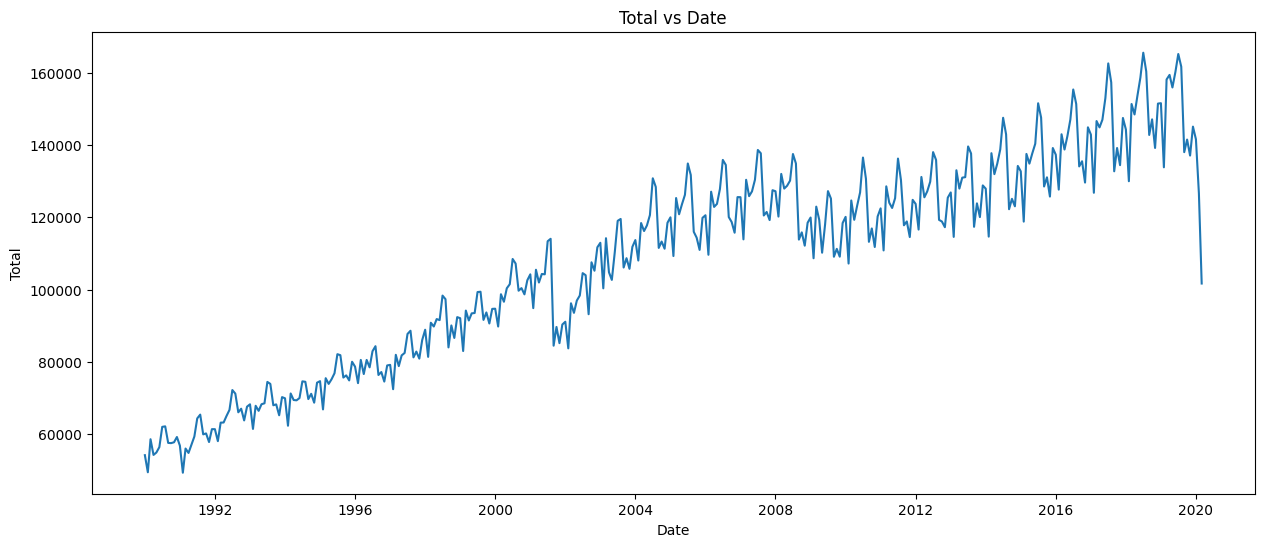

In [74]:
### departures
plt.figure(figsize=(15,6))
out_total = depart_df.groupby('data_dte')['Total'].sum().reset_index(name ='Total')
sns.lineplot(x='data_dte',y='Total',data=out_total)
plt.title("Total vs Date")
plt.xlabel("Date")
plt.ylabel("Total")
plt.show()

In [75]:
### departures
out_total.describe()

,Total
count,363.000000
mean,107719.011019
std,28361.417789
min,49264.000000
25%,82633.000000
50%,113395.000000
75%,128677.000000
max,165616.000000


Analyzing Charter vs Scheduled

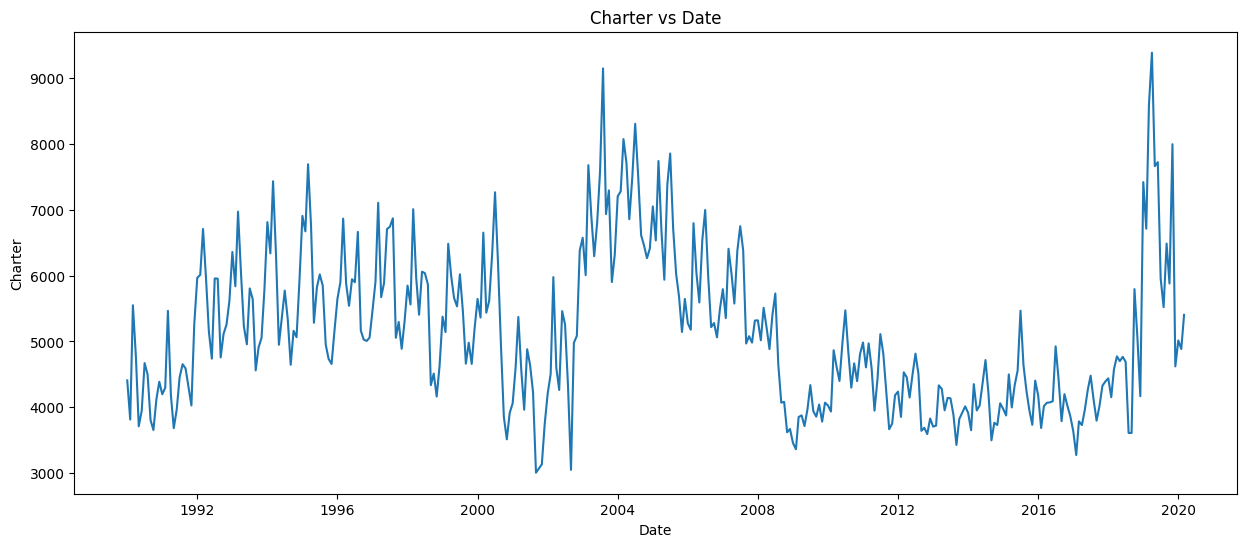

In [76]:
### departures
plt.figure(figsize=(15,6))
out_charter = depart_df.groupby('data_dte')['Charter'].sum().reset_index(name ='Charter')
sns.lineplot(x='data_dte',y='Charter',data=out_charter)
plt.title("Charter vs Date")
plt.xlabel("Date")
plt.ylabel("Charter")
plt.show()


In [77]:
### departures
out_charter.describe()

,Charter
count,363.000000
mean,5142.479339
std,1176.059697
min,3007.000000
25%,4184.000000
50%,4978.000000
75%,5905.500000
max,9382.000000


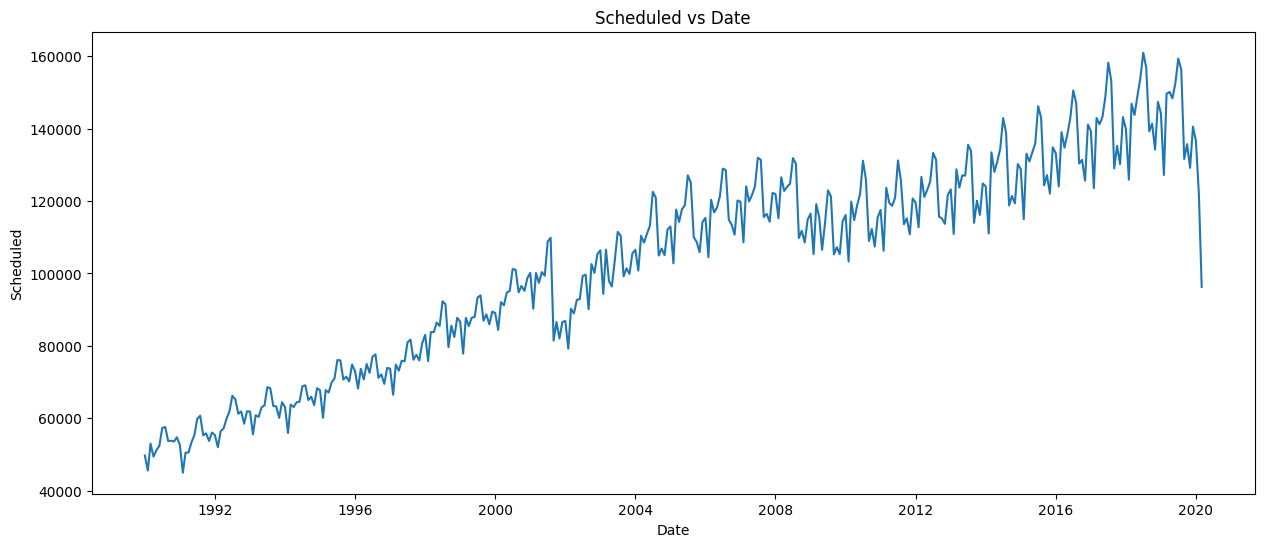

In [78]:
### departures
plt.figure(figsize=(15,6))
out_scheduled = depart_df.groupby('data_dte')['Scheduled'].sum().reset_index(name ='Scheduled')
sns.lineplot(x='data_dte',y='Scheduled',data=out_scheduled)
plt.title("Scheduled vs Date")
plt.xlabel("Date")
plt.ylabel("Scheduled")
plt.show()

In [79]:
### departures
out_scheduled.describe()

,Scheduled
count,363.000000
mean,102576.531680
std,28467.779514
min,44968.000000
25%,76593.000000
50%,108506.000000
75%,124008.000000
max,160926.000000


        We must evaluate charter departures separately since, as we have already seen, they are less frequent than scheduled departures. The graphics demonstrate how this situation causes the entire curve to be almost equivalent to the scheduled one.

        We are unable to identify a growth pattern in the chart of charter departures. Between 1990 and 1996, it grew; following that, it was relatively constant with some pikes until 2010, when it suddenly decreased. It then recovered, peaking in value in 2004, after which a steady drop started. This pattern can be traced back to 2010, when it suddenly increased at the beginning of 2020, reaching its greatest level since 1990, before beginning to drop in the months that followed. The maximum was 9382, and the mean was about 5142. We can see some seasonality there; eventually, we'll look into it more thoroughly.

        On the graph of the scheduled departures, there is a clear seasonality and an upward trend. Between 2000 to 2004, there was a decline, which swiftly recovered. In 2020, we started to notice the start of the pandemic's effects. Sadly, there are just a few months of this year in the dataset.


##### Looking to the passengers dataframe

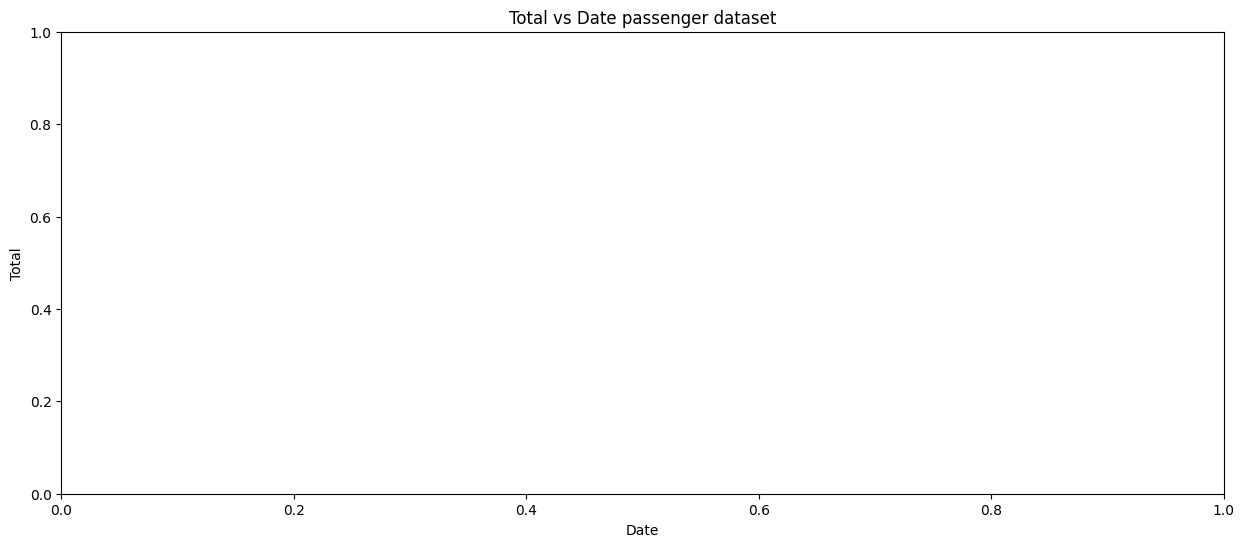

In [80]:
### passengers
plt.figure(figsize=(15,6))
out_total = pass_df.groupby('data_dte')['Total'].sum().reset_index(name ='Total')
sns.lineplot(x='data_dte',y='Total',data=out_total)
plt.title("Total vs Date passenger dataset")
plt.xlabel("Date")
plt.ylabel("Total")
plt.show()

In [81]:
### passengers
out_total.describe()

,Total
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


Analyzing Charter vs Scheduled

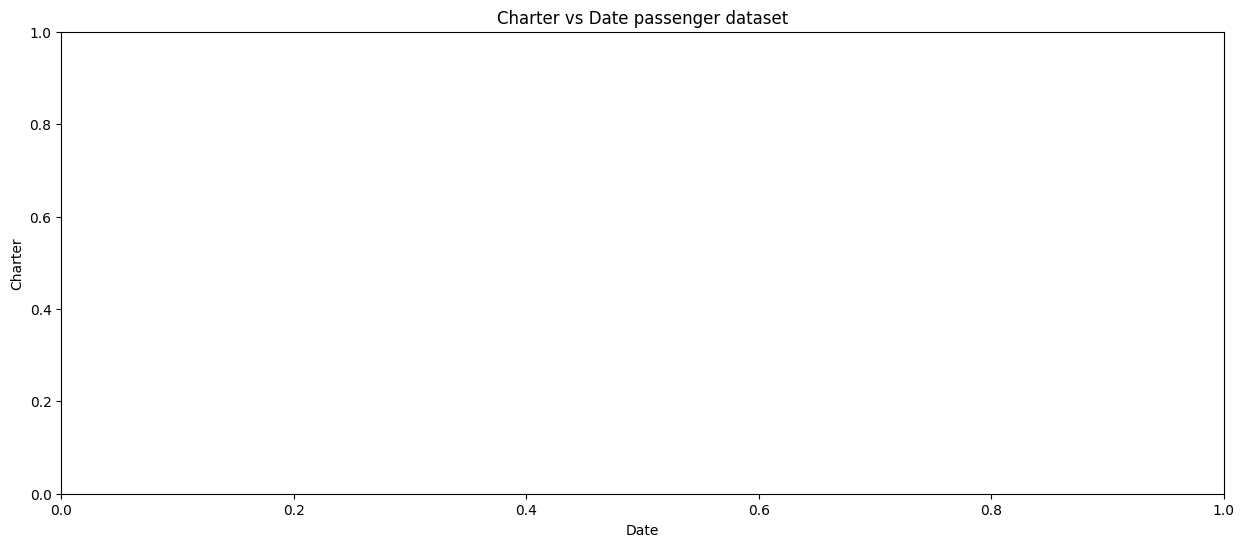

In [82]:
### passengers
plt.figure(figsize=(15,6))
out_charter = pass_df.groupby('data_dte')['Charter'].sum().reset_index(name ='Charter')
sns.lineplot(x='data_dte',y='Charter',data=out_charter)
plt.title("Charter vs Date passenger dataset")
plt.xlabel("Date")
plt.ylabel("Charter")
plt.show()

In [83]:
### passengers
out_charter.describe()

,Charter
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


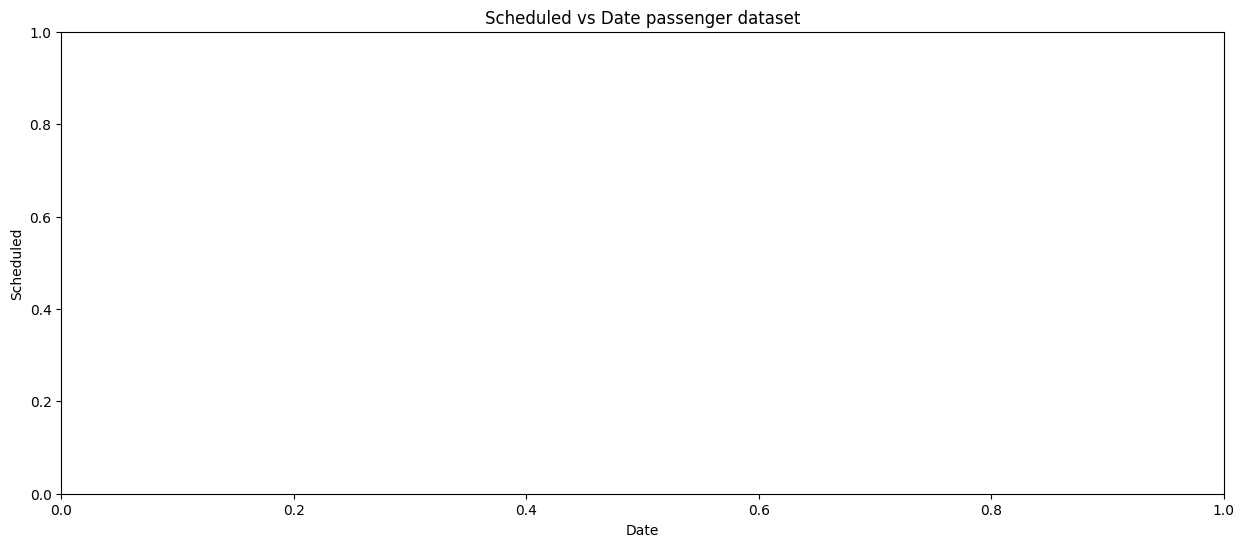

In [84]:
### passengers
plt.figure(figsize=(15,6))
out_scheduled = pass_df.groupby('data_dte')['Scheduled'].sum().reset_index(name ='Scheduled')
sns.lineplot(x='data_dte',y='Scheduled',data=out_scheduled)
plt.title("Scheduled vs Date passenger dataset")
plt.xlabel("Date")
plt.ylabel("Scheduled")
plt.show()

In [85]:
### passengers
out_scheduled.describe()

,Scheduled
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


        The graphs show how comparable the patterns in the passenger dataset are to those in the departure dataset.

        In the case of charters, there is a propensity for this to decrease over time. With a little gain in the early years, roughly from 1990 to 1994, it then starts to decline. Some seasonality exists.

        However, the trend is upward for those that are scheduled. The reduction between 2000 and 2004 is also visible, but it subsequently resumed its upward trend until 2020, when it abruptly fell, as we now know due to the pandemic. There is a visible seasonality.

##### Analizing the last five years

In [86]:
# month list
months = mn[1:]

### departures
max_year_depart = depart_df["Year"].max()
### passengers
max_year_pass = pass_df["Year"].max()

### departures
depart_df['month_category'] = depart_df['Month'].apply(lambda x: calendar.month_name[x])

### passengers
pass_df['month_category'] = pass_df['Month'].apply(lambda x: calendar.month_name[x])

# convert the column to categorical and ordered
### departures
depart_df["month_category"] = pd.Categorical(depart_df["month_category"], categories=months, ordered=True)
### passengers
pass_df["month_category"] = pd.Categorical(pass_df["month_category"], categories=months, ordered=True)

### departures
depart_df_last_5_years = depart_df.loc[(depart_df['Year'] >= (max_year_depart-4)) & (depart_df['Year'] <= max_year_depart)]
### passengers
pass_df_last_5_years = pass_df.loc[(pass_df['Year'] >= (max_year_pass-4)) & (pass_df['Year'] <= max_year_pass)]

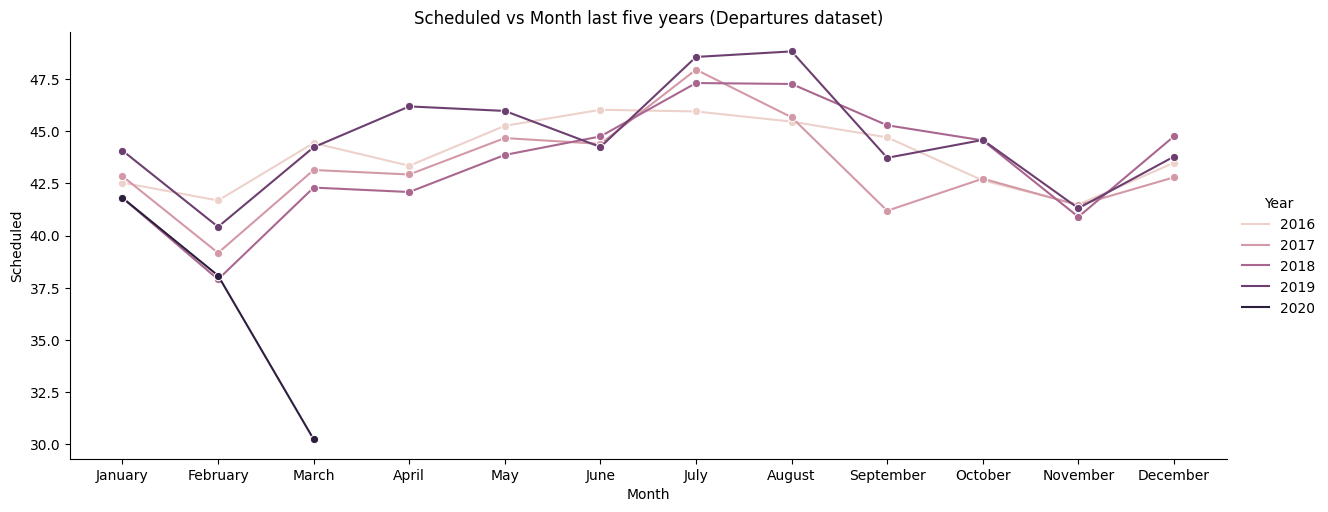

In [87]:
### departures
sns.relplot(kind='line', data=depart_df_last_5_years, x='month_category', y='Scheduled', hue='Year', aspect=2.5, marker='o', errorbar=None, height=5)
plt.title("Scheduled vs Month last five years (Departures dataset)")
plt.xlabel("Month")
plt.ylabel("Scheduled")
plt.show()

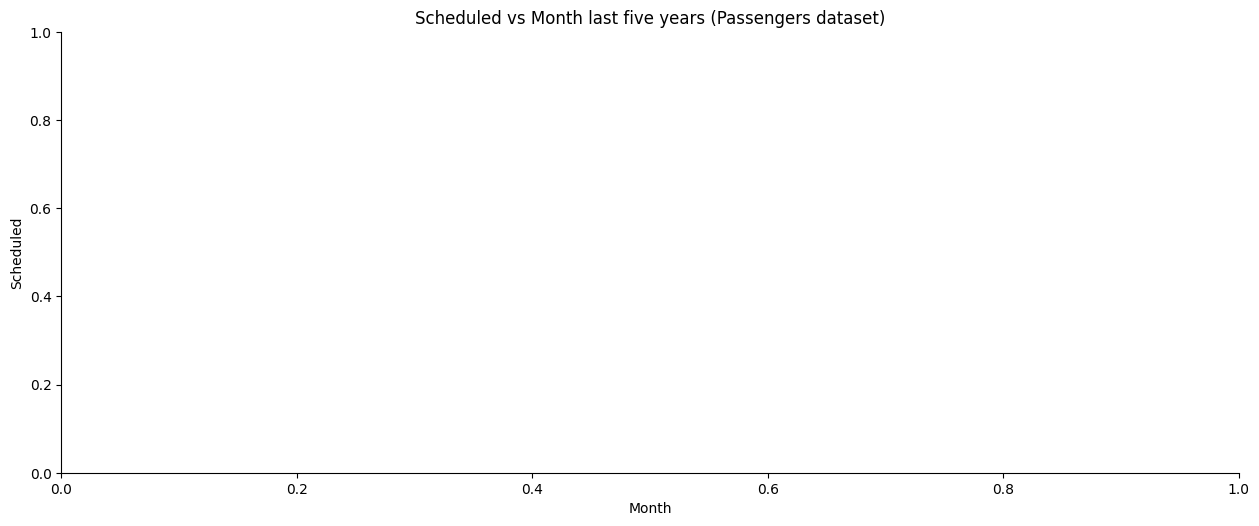

In [88]:
### passengers
sns.relplot(kind='line', data=pass_df_last_5_years, x='month_category', y='Scheduled', hue='Year', aspect=2.5, marker='o', errorbar=None, height=5)
plt.title("Scheduled vs Month last five years (Passengers dataset)")
plt.xlabel("Month")
plt.ylabel("Scheduled")
plt.show()


        We can see the seasonality in these two graphs. In the case of the scheduled flights, there are several similarities between the two datasets. The largest numbers are in July and August, while the lowest values are in February. After beginning in January about the middle, it drops in February, climbs in March, and diminishes in April . Then, beginning in May, the amount rises through August before falling in September, grows a little in October, drops off in November, then picks back up in December. Over the past five years, there has been a recurring pattern.

        2020 is the exception. Due to the pandemic, it should have increased in March but instead fell to its lowest level.

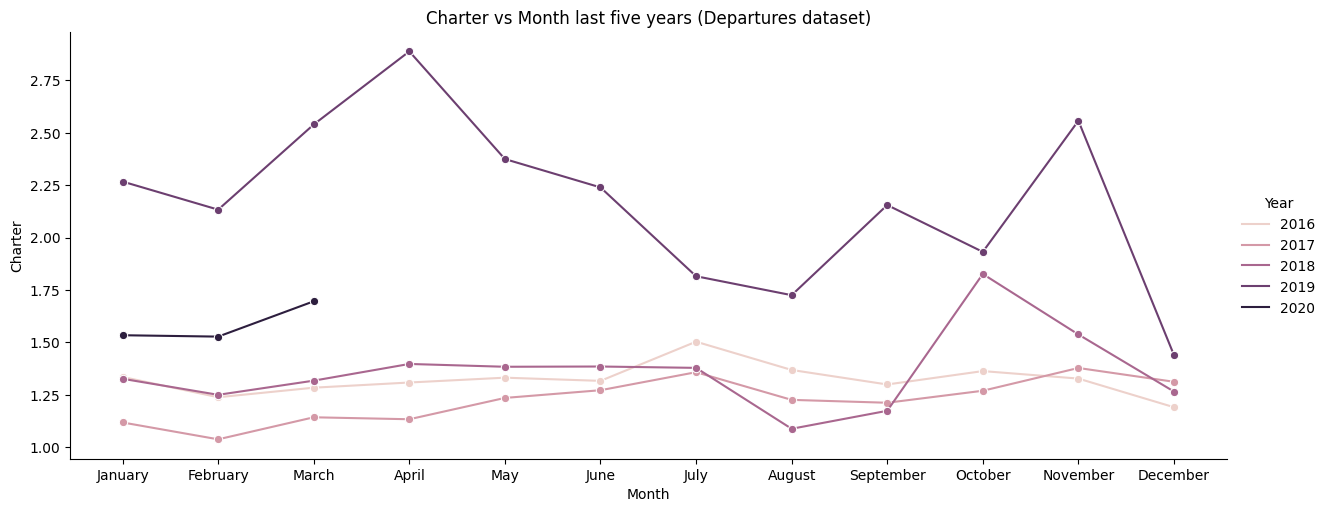

In [89]:
### departures
sns.relplot(kind='line', data=depart_df_last_5_years, x='month_category', y='Charter', hue='Year', aspect=2.5, marker='o', errorbar=None, height=5)
plt.title("Charter vs Month last five years (Departures dataset)")
plt.xlabel("Month")
plt.ylabel("Charter")
plt.show()

In [90]:
### passengers
sns.relplot(kind='line', data=pass_df_last_5_years, x='month_category', y='Charter', hue='Year', aspect=2.5, marker='o', errorbar=None, height=5)
plt.title("Charter vs Month last five years (Passengers dataset)")
plt.xlabel("Month")
plt.ylabel("Charter")
plt.show()

        It differs between the two datasets for charter flights.

        With the exception of October 2018, which grew significantly more than the rest of the years, the departures dataset's seasonality can be appreciated during the first three years of analysis. However, 2019 follows a different pattern, and the values rise much more dramatically. Up to March, the final month we have, it seems to start recovering the old pattern in 2020. The values here are lowest in the initial years.

        In contrast, the passenger dataset's beginning years had the highest numbers, and 2019 shows a fall. 2020 is out of the question because of the enormous behavioural change brought on by the epidemic.



### Sandra